# Deep Learning
This python file will use a feed forward neural network to predict the crime that is most likely to happen given a set of of features detailing the environment and situation beforehand. This would be particular useful in predicting crime so that police activity could be more efficient

The file will be split up in converting data similar to the baseline learning file. Performing deep learning and drawing conclusions based off of graph or tabular visualizations.


**Authors:** Kevin Lu, Shrusti Jain, Smeet Patel, Taobo Liao

# Imports and Graph Configurations

In [5]:
import numpy as np
import pandas as pd
import datetime
import torch.nn as nn
#%matplotlib notebook
import matplotlib.pyplot as plt

In [6]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

In [7]:
#download train and debug
!pip install gdown
!gdown 1enR3DLH7iDuI0mG8rV3Z21tPhdZZRXOv
!gdown 1zeyltSH_KaN0qQCRCiZR8kXOG6VUXU9T

Defaulting to user installation because normal site-packages is not writeable


Downloading...
From (original): https://drive.google.com/uc?id=1enR3DLH7iDuI0mG8rV3Z21tPhdZZRXOv
From (redirected): https://drive.google.com/uc?id=1enR3DLH7iDuI0mG8rV3Z21tPhdZZRXOv&confirm=t&uuid=8f2e01c2-372a-444c-9d16-25a51c86fe28
To: c:\Users\jain9\Predicting_LA_Crimes\src\train.pkl

  0%|          | 0.00/224M [00:00<?, ?B/s]
  0%|          | 524k/224M [00:00<00:45, 4.93MB/s]
  1%|▏         | 3.15M/224M [00:00<00:15, 14.6MB/s]
  2%|▏         | 5.24M/224M [00:00<00:12, 17.1MB/s]
  4%|▎         | 7.86M/224M [00:00<00:11, 19.3MB/s]
  4%|▍         | 9.96M/224M [00:00<00:10, 19.8MB/s]
  6%|▌         | 12.6M/224M [00:00<00:10, 20.4MB/s]
  7%|▋         | 15.2M/224M [00:00<00:09, 21.1MB/s]
  8%|▊         | 17.8M/224M [00:00<00:09, 21.8MB/s]
  9%|▉         | 20.4M/224M [00:01<00:09, 21.6MB/s]
 10%|█         | 23.1M/224M [00:01<00:09, 21.5MB/s]
 11%|█▏        | 25.7M/224M [00:01<00:08, 22.0MB/s]
 13%|█▎        | 28.3M/224M [00:01<00:08, 21.7MB/s]
 14%|█▍        | 30.9M/224M [00:01<00:08, 21.5

In [8]:
crime_df_train = pd.read_pickle('train.pkl')
crime_df_debug = pd.read_pickle('debug.pkl')

# Data Conversion

In [9]:
# Add a binary column indicating if Vict Age is 0
crime_df_train['Vict Age Was 0'] = (crime_df_train['Vict Age'] == 0).astype(int)

# Select relevant columns for analysis
selected_columns = [
    'Status',
    'Weapon Used Cd',
    'Vict Descent',
    'Vict Sex',
    'Vict Age',
    'Mocodes',
    'Crm Cd',
    'Part 1-2',
    'Rpt Dist No',
    'AREA',
    'TIME OCC',
    'DATE OCC',
    'Premis Cd',
    'Vict Age Was 0'
]

# Create a DataFrame with only the selected columns
crime_selected_df = crime_df_train[selected_columns]
crime_selected_df.head()

,Status,Weapon Used Cd,Vict Descent,Vict Sex,Vict Age,Mocodes,Crm Cd,Part 1-2,Rpt Dist No,AREA,TIME OCC,DATE OCC,Premis Cd,Vict Age Was 0
0,AA,NaN,O,M,0,NaN,510,1,784,7,2130,2020-03-01,101.0,1
1,IC,NaN,O,M,47,1822 1402 0344,330,1,182,1,1800,2020-02-08,128.0,0
2,IC,NaN,X,X,19,0344 1251,480,1,356,3,1700,2020-11-04,502.0,0
3,IC,NaN,O,M,19,0325 1501,343,1,964,9,2037,2020-03-10,405.0,0
4,IC,NaN,H,M,28,1822 1501 0930 2004,354,2,666,6,1200,2020-08-17,102.0,0


In [10]:
counts = crime_selected_df['Crm Cd'].value_counts()
codes = counts[counts>500].index.tolist()

We will convert all categorical values (even numerical categorical values) into one-hot encoded vectors for training. For 'Mocodes', there are 734 unique values. However, most of these values have less than 50 instances across the dataset which could cause higher bias. In addition, we ran into RAM issues when using all the Mocodes so we decided to stick with Mocodes with more than 1000 instances.

In [11]:
def convert_to_minutes(military_time):
    """
    Convert military time to minutes from midnight.

    Parameters:
    military_time (int): Time in military format, e.g., 2305 for 11:05 PM.

    Returns:
    int: Total minutes from midnight.
    """
    # Ensure the time is a four-digit string (e.g., '2305')
    military_time = str(military_time).zfill(4)

    # Extract hours and minutes from the string
    hours = int(military_time[:2])
    minutes = int(military_time[2:])

    # Calculate and return the total minutes from midnight
    total_minutes = hours * 60 + minutes
    return total_minutes

# Apply the convert_to_minutes function to 'TIME OCC' column
crime_selected_df['TIME OCC'] = crime_selected_df['TIME OCC'].apply(convert_to_minutes)

# Function to one-hot encode specified categorical columns
def one_hot_encode(df, columns):
    """
    Apply one-hot encoding to specified columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): List of columns to one-hot encode.

    Returns:
    pd.DataFrame: DataFrame with one-hot encoded columns.
    """
    for column in columns:

        # Create one-hot encoded columns for each category in the column
        one_hot = pd.get_dummies(df[column], prefix=column)

        # Convert one-hot encoded DataFrame to integer type for compactness
        one_hot = one_hot.astype(int)

        # Replace the original column with the one-hot encoded columns
        df[column] = one_hot.values.tolist()
    return df

# Function to multi-hot encode 'Mocodes' column where each row may contain multiple codes
def multi_hot_encode_mocodes(df):
    """
    Multi-hot encode the 'Mocodes' column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: DataFrame with 'Mocodes' column as multi-hot encoded vectors.
    """
    # Initialize a set of all unique Mocodes for multi-hot encoding
    mocode_counts = {}

    # Populate the set with unique Mocodes from each row (handling NaN values)
    for mocode_str in df['Mocodes'].dropna():
        mocode_str = str(mocode_str)
        mocodes = mocode_str.split(' ')
        for mocode in mocodes:
            mocode_counts[mocode] = mocode_counts.get(mocode, 0) + 1

    filtered_mocodes = {mocode for mocode, count in mocode_counts.items() if count > 1000}
    filtered_mocodes.add('NaN')
    mocode_index = {mocode: idx for idx, mocode in enumerate(sorted(filtered_mocodes))}

    # Define a helper function to encode Mocodes into a binary vector
    def encode_mocodes(mocode_str):
        # Split the Mocode string into individual codes, or set to 'NaN' if empty
        if isinstance(mocode_str, str):
            mocodes = mocode_str.split()
        else:
            mocodes = ['NaN']

        # Initialize a zero vector and set indices for each Mocode found
        encoded_vector = [0] * len(mocode_index)
        for mocode in mocodes:
            if mocode in mocode_index:
                encoded_vector[mocode_index[mocode]] = 1
        return encoded_vector

    # Apply the encoding function to the 'Mocodes' column
    df['Mocodes'] = df['Mocodes'].apply(encode_mocodes)
    return df, mocode_index

# Specify columns to one-hot encode
columns_to_encode = ['Status', 'Vict Descent', 'Vict Sex', 'Weapon Used Cd', 'Part 1-2']

# Apply one-hot encoding to specified columns and store the result in a new DataFrame
crime_selected_one_hot_df = one_hot_encode(crime_selected_df.copy(), columns_to_encode)

crime_selected_one_hot_df, mocode_index = multi_hot_encode_mocodes(crime_selected_one_hot_df.copy())
crime_selected_one_hot_df.head()

C:\Users\jain9\AppData\Local\Temp\ipykernel_23724\3696011145.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_selected_df['TIME OCC'] = crime_selected_df['TIME OCC'].apply(convert_to_minutes)


,Status,Weapon Used Cd,Vict Descent,Vict Sex,Vict Age,Mocodes,Crm Cd,Part 1-2,Rpt Dist No,AREA,TIME OCC,DATE OCC,Premis Cd,Vict Age Was 0
0,"[1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0]",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",510,"[1, 0]",784,7,1290,2020-03-01,101.0,1
1,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0]",47,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",330,"[1, 0]",182,1,1080,2020-02-08,128.0,0
2,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1]",19,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",480,"[1, 0]",356,3,1020,2020-11-04,502.0,0
3,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0]",19,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",343,"[1, 0]",964,9,1237,2020-03-10,405.0,0
4,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0]",28,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",354,"[0, 1]",666,6,720,2020-08-17,102.0,0


In [12]:
crime_selected_one_hot_df['DATE OCC INT'] = crime_selected_one_hot_df['DATE OCC'].astype('int64') // (10**9 * 60 * 60 * 24)

In [13]:
d2024 = datetime.datetime(2024, 1, 1, 0, 0)
t2024 = d2024.timestamp() // (60 * 60 * 24)
d2023 = datetime.datetime(2023, 1, 1, 0, 0)
t2023 = d2023.timestamp() // (60 * 60 * 24)

## Identifying Null Values of Selected Features and Replacing them with 0s

In [14]:
crime_selected_one_hot_df [['Status','Weapon Used Cd','Vict Descent','Vict Sex','Vict Age','Crm Cd','Part 1-2','Rpt Dist No','AREA','TIME OCC','DATE OCC','Premis Cd','Vict Age Was 0']].isna().any()

Status            False
Weapon Used Cd    False
Vict Descent      False
Vict Sex          False
Vict Age          False
Crm Cd            False
Part 1-2          False
Rpt Dist No       False
AREA              False
TIME OCC          False
DATE OCC          False
Premis Cd          True
Vict Age Was 0    False
dtype: bool

In [15]:
crime_selected_one_hot_df['Premis Cd'] = crime_selected_one_hot_df['Premis Cd'].fillna(0)

In [16]:
non_list = crime_selected_one_hot_df[['DATE OCC INT', 'Vict Age Was 0', 'Vict Age', 'Rpt Dist No', 'AREA', 'TIME OCC','Premis Cd']].to_numpy(dtype=np.float32)

In [17]:
print(f'Status shape: {np.array(crime_selected_one_hot_df["Status"].to_list()).shape}')
print(f'Weapon Used Cd shape: {np.array(crime_selected_one_hot_df["Weapon Used Cd"].to_list()).shape}')
print(f'Vict Descent shape: {np.array(crime_selected_one_hot_df["Vict Descent"].to_list()).shape}')
print(f'Vict Sex shape: {np.array(crime_selected_one_hot_df["Vict Sex"].to_list()).shape}')
print(f'Mocodes shape: {np.array(crime_selected_one_hot_df["Mocodes"].to_list()).shape}')

Status shape: (986500, 6)
Weapon Used Cd shape: (986500, 79)
Vict Descent shape: (986500, 20)
Vict Sex shape: (986500, 5)
Mocodes shape: (986500, 180)


Initializing our X and Y (label) vectors in numpy.

In [18]:
X = np.concatenate([non_list, np.array(crime_selected_one_hot_df['Status'].to_list()), np.array(crime_selected_one_hot_df['Weapon Used Cd'].to_list()), np.array(crime_selected_one_hot_df['Vict Descent'].to_list()), np.array(crime_selected_one_hot_df['Vict Sex'].to_list()), np.array(crime_selected_one_hot_df['Mocodes'].to_list())], axis=1)

For our labels, we decided to one hot encode the crime codes and make this a classification problem rather than regression. With regression, we were only able to achieve around 20% accuracy. In addition, we are only using crime codes with more than 500 occurences. This is to improve the stability in training as we found when using all crime codes, due to codes some have 1 or 2 training points, would get very high variance.

In [19]:
Y = crime_selected_one_hot_df['Crm Cd'].to_numpy()
unique_classes = np.unique(Y)
counts = crime_selected_df['Crm Cd'].value_counts()
retained_classes = counts[counts>500].index.tolist()
removed_classes = counts[counts<=500].index.tolist()
class_to_index = {cls: idx for idx, cls in enumerate(retained_classes)}
class_to_index.update({cls: len(retained_classes) for cls in removed_classes})
Y_indices = np.array([class_to_index[cls] for cls in Y])
size = crime_selected_one_hot_df.shape[0]
weights = counts[counts>500].to_list()
weights.append(counts[counts<=500].sum())
weights = (np.sqrt(crime_selected_one_hot_df['Crm Cd'].shape[0]/np.array(weights)))/10
Y_one_hot = np.zeros((len(Y), len(retained_classes)+1), dtype=np.float32)
Y_one_hot[np.arange(len(Y)), Y_indices] = 1
Y_part12 = np.array(crime_selected_one_hot_df['Part 1-2'].to_list())
print(f"One-hot encoded Y shape: {Y_one_hot.shape}")
print(f"One-hot encoded Part 1-2 Y shape: {Y_part12.shape}")

One-hot encoded Y shape: (986500, 69)
One-hot encoded Part 1-2 Y shape: (986500, 2)


# Deep Learning

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

# Initializing our dataset for x features and y labels
class CrimeDataset(Dataset):
    def __init__(self, features, crimes):
        self.features = features
        self.labels = crimes

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

In [21]:
# We will utilize the GPU for faster training. In addition, we need to change all numpy arrays to torch.tensors to train our model.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_torch = torch.tensor(X, dtype=torch.float32).to(device)
print(X_torch.shape)
Y_torch = torch.tensor(Y_one_hot, dtype=torch.float32).to(device)
dataset = CrimeDataset(X_torch, Y_torch)

# Initialization of our dataset will be 70/20/10 split being training, validation, and test respectively
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [.70, .20, .10])
train_loader = DataLoader(train_set, batch_size=4096, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4096, shuffle=False)

torch.Size([986500, 297])


In [22]:
# Basic Neural Network with 3 hidden layers, BatchNorm and dropout
class BasicNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate):
        super(BasicNN, self).__init__()
        self.layers = nn.Sequential(
            # Input layer
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),

            # Hidden Layer 1
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),

            # Hidden Layer 2
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.BatchNorm1d(hidden_sizes[2]),
            nn.ReLU(),

            # Hidden Layer 3 (New layer added)
            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
            nn.BatchNorm1d(hidden_sizes[3]),
            nn.ReLU(),

            # Output layer
            nn.Linear(hidden_sizes[3], output_size),
        )

    def forward(self, x):
        return self.layers(x)


In [23]:
# These functions will be used for training the model and evaluating the model on the validation dataset respectively
def train(model, optimizer, train_loader, valid_loader, criterion, steps_per_eval=100, epochs=30):
    acc = 0
    global_steps = 0
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch_idx, (features, crimes) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(features).squeeze()
            loss = criterion(output, crimes)
            loss.backward()
            optimizer.step()
            global_steps += 1
            if global_steps % steps_per_eval == 0:
                print(f"Step {global_steps}, Loss {loss.item():.4f}")
                acc = evaluate(model, valid_loader)
                print(f"Step {global_steps}, Validation Accuracy: {acc:.2f}")
    return acc

def evaluate(model, valid_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, crimes in valid_loader:
            output = model(features)
            if(len(crimes.shape)==2):
              pred = output.argmax(dim=1)
              true = crimes.argmax(dim=1)
              correct += (pred == true).sum().item()
            else:
              correct += (output == crimes).sum().item()
            total += crimes.size(0)
    return correct / total


In [24]:
!gdown 1EIjheBnJBAHCEoa_Ejk5ErAYwMp1j33U
results_df = pd.read_csv('different_Optimizers_training_results.csv')

Downloading...
From: https://drive.google.com/uc?id=1EIjheBnJBAHCEoa_Ejk5ErAYwMp1j33U
To: c:\Users\jain9\Predicting_LA_Crimes\src\different_Optimizers_training_results.csv

  0%|          | 0.00/13.8k [00:00<?, ?B/s]
100%|██████████| 13.8k/13.8k [00:00<?, ?B/s]


In [25]:
# Creating a pivot table with different hyperparameters and their accuracy with each epochs
pivot_table = results_df.pivot_table(
    index="Epoch",
    columns=["Optimizer", "Learning Rate", "Dropout Rate"],
    values="Validation Accuracy",
    aggfunc="mean"
)

# Display the pivot table with validation accuracy as values
print(pivot_table)

Optimizer          Adam                                 RMSprop            \
Learning Rate    0.0001              0.0010              0.0001             
Dropout Rate        0.2       0.3       0.2       0.3       0.2       0.3   
Epoch                                                                       
1              0.142904  0.208003  0.113568  0.113791  0.239595  0.207476   
2              0.287501  0.286254  0.204810  0.178302  0.250076  0.260142   
3              0.303274  0.297344  0.239762  0.263183  0.232002  0.269179   
4              0.348865  0.342235  0.136412  0.314754  0.255773  0.263634   
5              0.353730  0.391698  0.289574  0.347121  0.234557  0.282190   
6              0.443386  0.363573  0.303264  0.395418  0.290760  0.285717   
7              0.441708  0.434577  0.328023  0.394800  0.302159  0.285666   
8              0.491708  0.451977  0.383948  0.432965  0.310552  0.312772   
9              0.509184  0.477770  0.397405  0.442833  0.290081  0.294992   

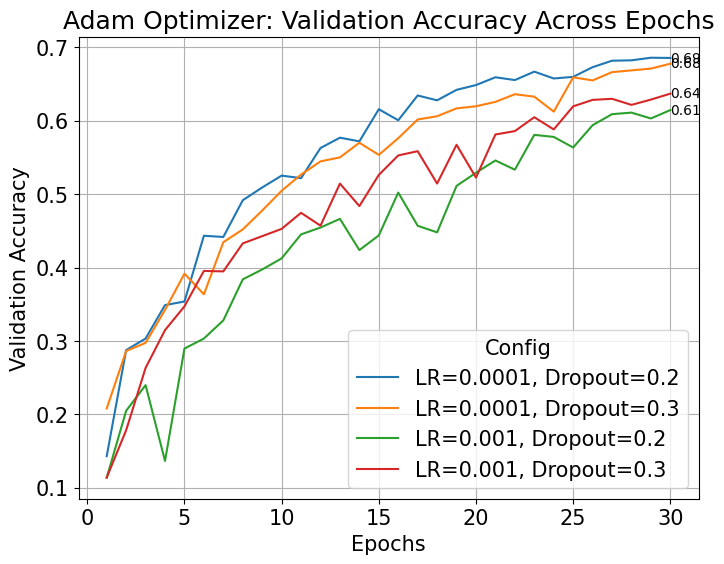

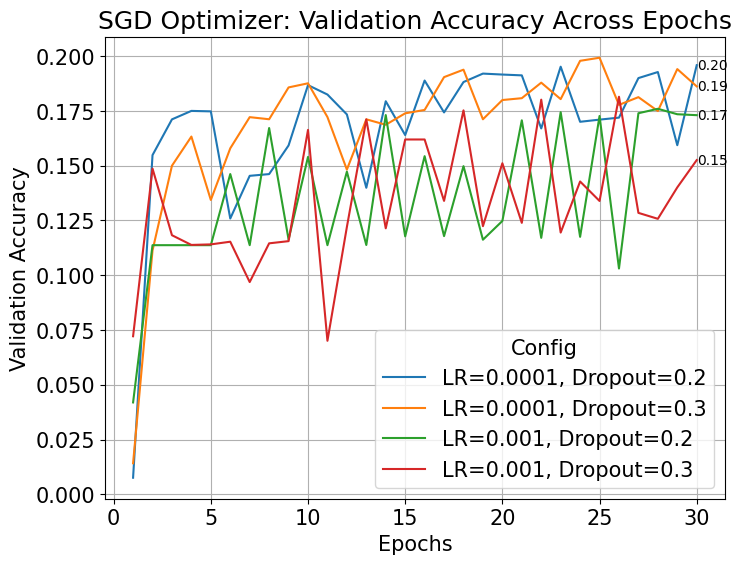

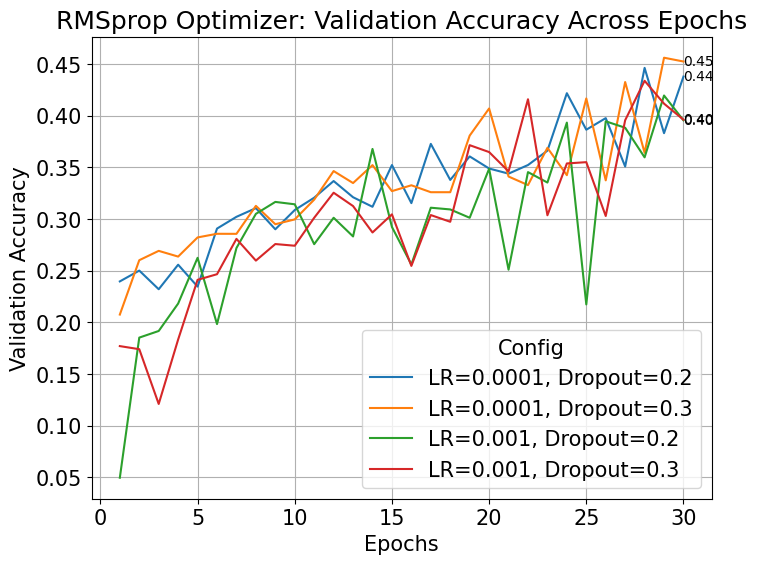

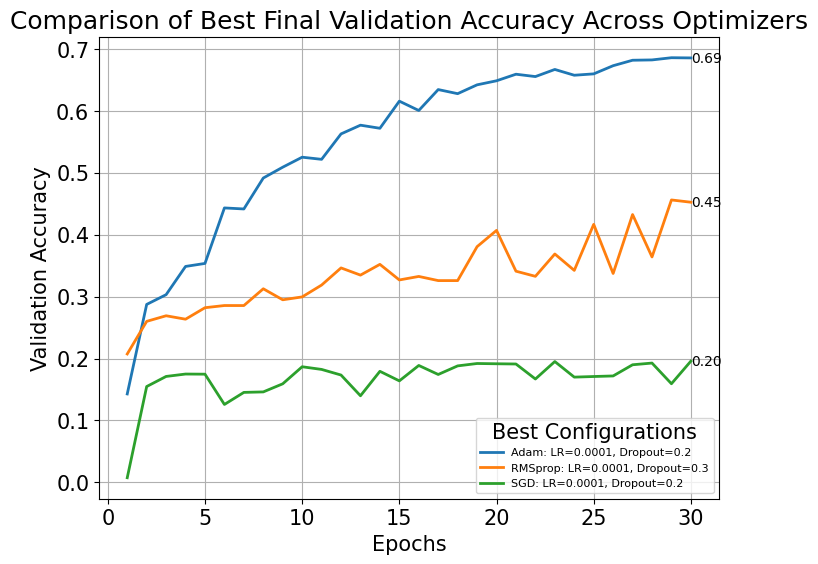

In [26]:
# Filter the data by optimizer
optimizers = ['Adam', 'SGD', 'RMSprop']
best_results = []  # To store the best result for each optimizer

for optimizer in optimizers:
    # Filter data for the specific optimizer
    optimizer_data = results_df[results_df['Optimizer'] == optimizer]

    plt.figure(figsize=(8, 6))  # Create a new figure for each optimizer

    # Iterate over combinations of learning rate and dropout
    for (lr, dropout), group_data in optimizer_data.groupby(['Learning Rate', 'Dropout Rate']):
        # Sort data by epoch to ensure correct line plotting
        group_data = group_data.sort_values(by='Epoch')
        # Plot validation accuracy over epochs with narrow lines
        plt.plot(
            group_data['Epoch'],
            group_data['Validation Accuracy'],
            label=f"LR={lr}, Dropout={dropout}",
            linewidth=1.5  # Narrower line
        )

        # Annotate the final validation accuracy value
        final_epoch = group_data['Epoch'].iloc[-1]
        final_val_acc = group_data['Validation Accuracy'].iloc[-1]
        plt.text(
            final_epoch,
            final_val_acc,
            f"{final_val_acc:.2f}",
            fontsize=10,
            ha='left',
            va='center'
        )

        # Track the best final validation accuracy for this optimizer
        best_results.append({
            "Optimizer": optimizer,
            "Learning Rate": lr,
            "Dropout Rate": dropout,
            "Validation Accuracy": final_val_acc,
            "Group Data": group_data  # Store data for plotting later
        })

    # Add titles, labels, and legend
    plt.title(f"{optimizer} Optimizer: Validation Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend(title="Config", loc='lower right')
    plt.grid(True)
    plt.show()

# Find the best final validation accuracy for each optimizer
best_results_df = pd.DataFrame(best_results)
best_results_df = best_results_df.loc[
    best_results_df.groupby("Optimizer")["Validation Accuracy"].idxmax()
]

# Plot the best lines for each optimizer
plt.figure(figsize=(8, 6))
for _, row in best_results_df.iterrows():
    group_data = row["Group Data"]
    plt.plot(
        group_data['Epoch'],
        group_data['Validation Accuracy'],
        label=f"{row['Optimizer']}: LR={row['Learning Rate']}, Dropout={row['Dropout Rate']}",
        linewidth=2.0  # Slightly thicker line for emphasis
    )
    # Annotate the final validation accuracy value
    final_epoch = group_data['Epoch'].iloc[-1]
    final_val_acc = group_data['Validation Accuracy'].iloc[-1]
    plt.text(
        final_epoch,
        final_val_acc,
        f"{final_val_acc:.2f}",
        fontsize=10,
        ha='left',
        va='center'
    )

# Add titles, labels, and legend
plt.title("Comparison of Best Final Validation Accuracy Across Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend(title="Best Configurations", loc='lower right', fontsize=8)
plt.grid(True)
plt.show()


Our baseline learning with a linear classifier gives us an accuracy of 45%. However, after using this more complex model to capture the underlying patterns in the dataset, we are able to arrive at around 68% top-1 accuracy which is a substantial increase using a deep learning model.

In [27]:
# Hyperparameters
# These are the best hyperparameters we found after hyperparameter tuning shown below.
input_size = 297
hidden_size = [256, 180, 120, 80]
output_size = 69
learning_rate = 1e-3
dropout_rate = 0.2
milestones = [10, 15]

# Adam outperforms SGD
model = BasicNN(input_size, hidden_size, output_size, dropout_rate).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(weights).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train(model, optimizer, train_loader, val_loader, criterion)
torch.save(model.state_dict(), 'basic_nn_model.pkl')

Epoch 1/30
Step 100, Loss 2.0871
Step 100, Validation Accuracy: 0.18
Epoch 2/30
Step 200, Loss 2.3574
Step 200, Validation Accuracy: 0.22
Step 300, Loss 2.1108
Step 300, Validation Accuracy: 0.26


KeyboardInterrupt: 

In [ ]:
#torch.save(model, 'basic_nn_model_full.pkl')
#breakline

Perform model evaluations with the test set

In [ ]:
!gdown 1GOlOSBBJdWWdh8z2oS19aEROm-3oTB4d
model = BasicNN(input_size=297, hidden_sizes=[256, 180, 120, 80], output_size=69, dropout_rate=0.2)
model.load_state_dict(torch.load('basic_nn_model.pkl', map_location=device))
model.to(device)
print(f"Final Test Set Evaluation Accuracy: {evaluate(model, test_loader)}")

Downloading...
From: https://drive.google.com/uc?id=1GOlOSBBJdWWdh8z2oS19aEROm-3oTB4d
To: /content/basic_nn_model.pkl
100% 658k/658k [00:00<00:00, 126MB/s]


<ipython-input-25-17eaadb8d689>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/basic_nn_model.pkl', map_location=device))


Final Test Set Evaluation Accuracy: 0.6133502280790674


Notes: Other experiments.

Test using Part 1/2 as label.
Train on data up until 2023 and then test on 2024 data.
Try using a multilevel classifier that first predicts Part 1/2 and then the crime.
Try transforming crime from one-hot to potentially have a category label -> multilevel again.

# Predicting Crime Severity

We try a simpler case as well: predicting if a crime is Part 1 or 2 with our model.

In [ ]:


Y_part12_torch = torch.tensor(Y_part12, dtype=torch.float32).to(device)
dataset = CrimeDataset(X_torch, Y_part12_torch)

# Initialization of our dataset will be 70/20/10 split being training, validation, and test respectively
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [.70, .20, .10])
train_loader = DataLoader(train_set, batch_size=4096, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4096, shuffle=False)

In [ ]:
input_size = 297
hidden_size = [256, 180, 120, 80]
output_size = 2
learning_rate = 1e-3
dropout_rate = 0.2
milestones = [10, 15]

# Adam outperforms SGD
part12_model = BasicNN(input_size, hidden_size, output_size, dropout_rate).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(part12_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
train(part12_model, optimizer, train_loader, val_loader, criterion)
# torch.save(model.state_dict(), 'basic_nn_model_part12.pkl')

Epoch 1/30
Step 100, Loss 0.3985
Step 100, Validation Accuracy: 0.60
Epoch 2/30
Step 200, Loss 0.6032
Step 200, Validation Accuracy: 0.67
Step 300, Loss 0.5945
Step 300, Validation Accuracy: 0.68
Epoch 3/30
Step 400, Loss 0.5625
Step 400, Validation Accuracy: 0.69
Step 500, Loss 0.5147
Step 500, Validation Accuracy: 0.73
Epoch 4/30
Step 600, Loss 0.5169
Step 600, Validation Accuracy: 0.74
Epoch 5/30
Step 700, Loss 0.5781
Step 700, Validation Accuracy: 0.70
Step 800, Loss 0.3964
Step 800, Validation Accuracy: 0.75
Epoch 6/30
Step 900, Loss 0.3379
Step 900, Validation Accuracy: 0.88
Step 1000, Loss 0.3030
Step 1000, Validation Accuracy: 0.87
Epoch 7/30
Step 1100, Loss 0.2737
Step 1100, Validation Accuracy: 0.90
Epoch 8/30
Step 1200, Loss 0.2947
Step 1200, Validation Accuracy: 0.85
Step 1300, Loss 0.2392
Step 1300, Validation Accuracy: 0.90
Epoch 9/30
Step 1400, Loss 0.2429
Step 1400, Validation Accuracy: 0.91
Step 1500, Loss 0.8751
Step 1500, Validation Accuracy: 0.60
Epoch 10/30
Step 16

0.8120020273694881

In [ ]:
print(f"Final Test Set Evaluation Accuracy: {evaluate(part12_model, test_loader)}")

Final Test Set Evaluation Accuracy: 0.931545869234668


In [ ]:
torch.save(part12_model.state_dict(), 'basic_nn_model_part12.pkl')

# Generalizing trends over time

In [ ]:
X_l2023 = X_torch[X_torch[:, 0] < t2023]
Y_l2023 = Y_torch[X_torch[:, 0] < t2023]
X_23to24 = X_torch[(X_torch[:, 0] >= t2023) & (X_torch[:, 0] < t2024)]
Y_23to24 = Y_torch[(X_torch[:, 0] >= t2023) & (X_torch[:, 0] < t2024)]
X_g2024 = X_torch[X_torch[:, 0] >= t2024]
Y_g2024 = Y_torch[X_torch[:, 0] >= t2024]

In [ ]:
train_set = CrimeDataset(X_l2023, Y_l2023)
val_set = CrimeDataset(X_23to24, Y_23to24)
test_set = CrimeDataset(X_g2024, Y_g2024)
train_loader = DataLoader(train_set, batch_size=4096, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4096, shuffle=False)

In [ ]:
# Hyperparameters
# These are the best hyperparameters we found after hyperparameter tuning shown below.
input_size = 297
hidden_size = [256, 180, 120, 80]
output_size = 69
learning_rate = 1e-3
dropout_rate = 0.2
milestones = [10, 15]

# Adam outperforms SGD
time_sensitive_model = BasicNN(input_size, hidden_size, output_size, dropout_rate).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(weights).to(device))
optimizer = torch.optim.Adam(time_sensitive_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train(time_sensitive_model, optimizer, train_loader, val_loader, criterion)
# torch.save(model.state_dict(), 'basic_nn_model.pkl')

Epoch 1/30
Step 100, Loss 2.1838
Step 100, Validation Accuracy: 0.09
Epoch 2/30
Step 200, Loss 2.3060
Step 200, Validation Accuracy: 0.24
Step 300, Loss 2.2437
Step 300, Validation Accuracy: 0.24
Epoch 3/30
Step 400, Loss 2.1366
Step 400, Validation Accuracy: 0.27
Epoch 4/30
Step 500, Loss 2.1295
Step 500, Validation Accuracy: 0.27
Step 600, Loss 2.0030
Step 600, Validation Accuracy: 0.31
Epoch 5/30
Step 700, Loss 1.9857
Step 700, Validation Accuracy: 0.30
Epoch 6/30
Step 800, Loss 1.9920
Step 800, Validation Accuracy: 0.35
Step 900, Loss 1.8300
Step 900, Validation Accuracy: 0.31
Epoch 7/30
Step 1000, Loss 1.7294
Step 1000, Validation Accuracy: 0.41
Step 1100, Loss 1.8435
Step 1100, Validation Accuracy: 0.38
Epoch 8/30
Step 1200, Loss 1.6005
Step 1200, Validation Accuracy: 0.45
Epoch 9/30
Step 1300, Loss 1.5115
Step 1300, Validation Accuracy: 0.40
Step 1400, Loss 1.6426
Step 1400, Validation Accuracy: 0.43
Epoch 10/30
Step 1500, Loss 1.4952
Step 1500, Validation Accuracy: 0.46
Epoch 1

0.5849496267772767

In [ ]:
print(f"Final Test Set Evaluation Accuracy: {evaluate(model, test_loader)}")

Final Test Set Evaluation Accuracy: 0.4609935552188122


In [ ]:
torch.save(model.state_dict(), 'basic_nn_model_time_sensitive.pkl')